In [207]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import copy

# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# from sklearn.grid_search import GridSearchCV
# from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif


%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', None) #will display all columns

# Utils

In [273]:
def check_nan(df):
    n_row = df.shape[0]
    df_nullsum = _get_ratio(df.isnull().sum(), n_row)
    df_null = df_nullsum[df_nullsum['count']>0]
    print(df_null)
    return df_null,df_nullsum

def _get_ratio(sr, n_row):
    df = pd.DataFrame(sr, columns=['count'])
    df['ratio(%)'] = df['count']/ n_row * 100.0
    return df

def chunk_data(chunksize,filename):
    total_rows = 0
    for i,df_chunk in enumerate(pd.read_csv(filename, chunksize=chunksize)):
        print(i, df_chunk.shape)
        total_rows += df_chunk.shape[0]
        df_chunk.to_pickle('train_sample_{}.pickle'.format(str(i)))
        print('total rows {}'.format(str(total_rows)))
        
def major_correls(df,thresh=0.9,drop=False):
    ord_n_num_cols = df._get_numeric_data().columns
    correls=df[ord_n_num_cols].corr()
    c1=[]
    c2=[]
    correl=[]
    num_ord_cols=len(ord_n_num_cols)
    for i in range(num_ord_cols-1):
        for j in np.arange((i+1),num_ord_cols):
            corr=correls.ix[i,j]
            if abs(corr)>=thresh:
                c1=np.append(c1,ord_n_num_cols[i])
                c2=np.append(c2,ord_n_num_cols[j])
                correl=np.append(correl,corr)
    df_correl=pd.DataFrame({'col1':c1,'col2':c2,'corr':correl,'abs_corr':abs(correl)})
    df_correl=df_correl.sort_values(by='abs_corr',ascending=False)
    if drop==True:
        drop_cols=df_correl['col1'].values
        new_df=df.drop(drop_cols,axis=1)
        return correls,df_correl,new_df
    else:
        return correls,df_correl

def major_vifs(df,thresh=10,drop=False):
    ord_n_num_cols = df._get_numeric_data().columns
    x=np.asmatrix(df[ord_n_num_cols])
    vif_vals = [round(vif(x, i),2) for i in range(x.shape[1])]
    df_vif=pd.DataFrame({'cols':ord_n_num_cols,'vif':vif_vals})
    df_vif=df_vif.sort_values(by='vif',ascending=False)
    df_high_vif=df_vif[df_vif['vif']>thresh]
    print('Columns with high vif:')
    print(df_high_vif)
    if drop==True:
        drop_cols=df_high_vif['cols'].values
        new_df=df.drop(drop_cols,axis=1)
        return correls,df_correl,new_df
    else:
        return df_vif,df_high_vif

# Utils Plot 

In [274]:
def draw_histograms(df, variables, n_rows, n_cols, df_null=''):
    fig=plt.figure(figsize=(15,30))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+', '+str(df_null['count'][i])+', '+str(round(df_null['ratio(%)'][i],2))+'%')
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

# Data Pre-process 

In [145]:
# df = pd.read_csv('train.csv')
# df.to_pickle('train.pickle')
df=pd.read_pickle('train.pickle')
df.shape

(1460, 81)

In [32]:
dfinfo=df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [33]:
numeric_cols = df._get_numeric_data().columns
print(numeric_cols)
cat_cols = set(df.columns)-set(numeric_cols)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [34]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
df_null,_=check_nan(df)
cols_with_nulls=df_null.index
len(cols_with_nulls),cols_with_nulls

              count   ratio(%)
LotFrontage     259  17.739726
Alley          1369  93.767123
MasVnrType        8   0.547945
MasVnrArea        8   0.547945
BsmtQual         37   2.534247
BsmtCond         37   2.534247
BsmtExposure     38   2.602740
BsmtFinType1     37   2.534247
BsmtFinType2     38   2.602740
Electrical        1   0.068493
FireplaceQu     690  47.260274
GarageType       81   5.547945
GarageYrBlt      81   5.547945
GarageFinish     81   5.547945
GarageQual       81   5.547945
GarageCond       81   5.547945
PoolQC         1453  99.520548
Fence          1179  80.753425
MiscFeature    1406  96.301370


(19, Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
        'MiscFeature'],
       dtype='object'))

(1460, 80)


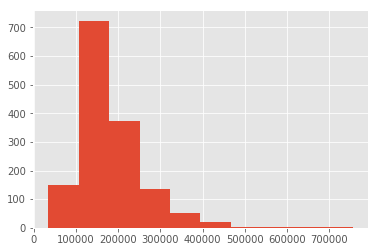

In [146]:
y=df['SalePrice']
df=df.drop(['SalePrice'],axis=1)
print(df.shape)
y.hist()

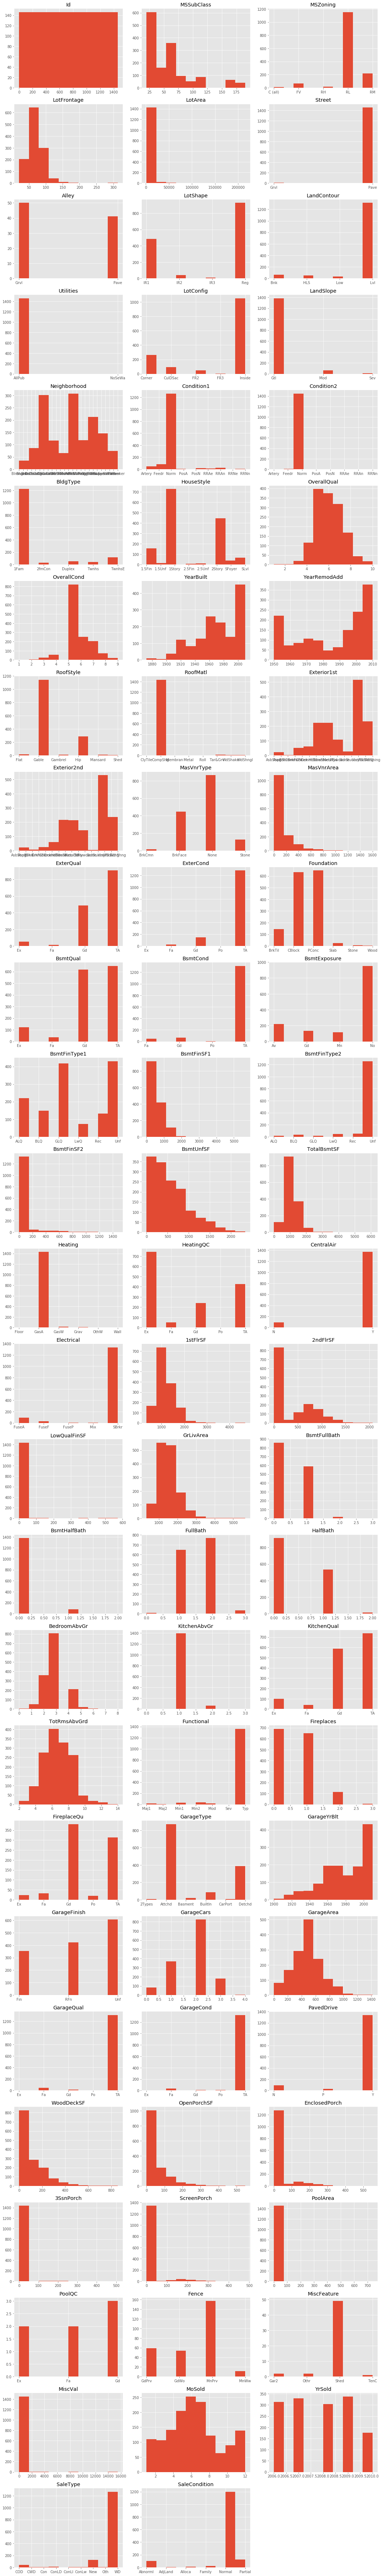

In [17]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,100))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df, df.columns, 27, 3)

## Fix Missing Values

In [38]:
len(cols_with_nulls)

19

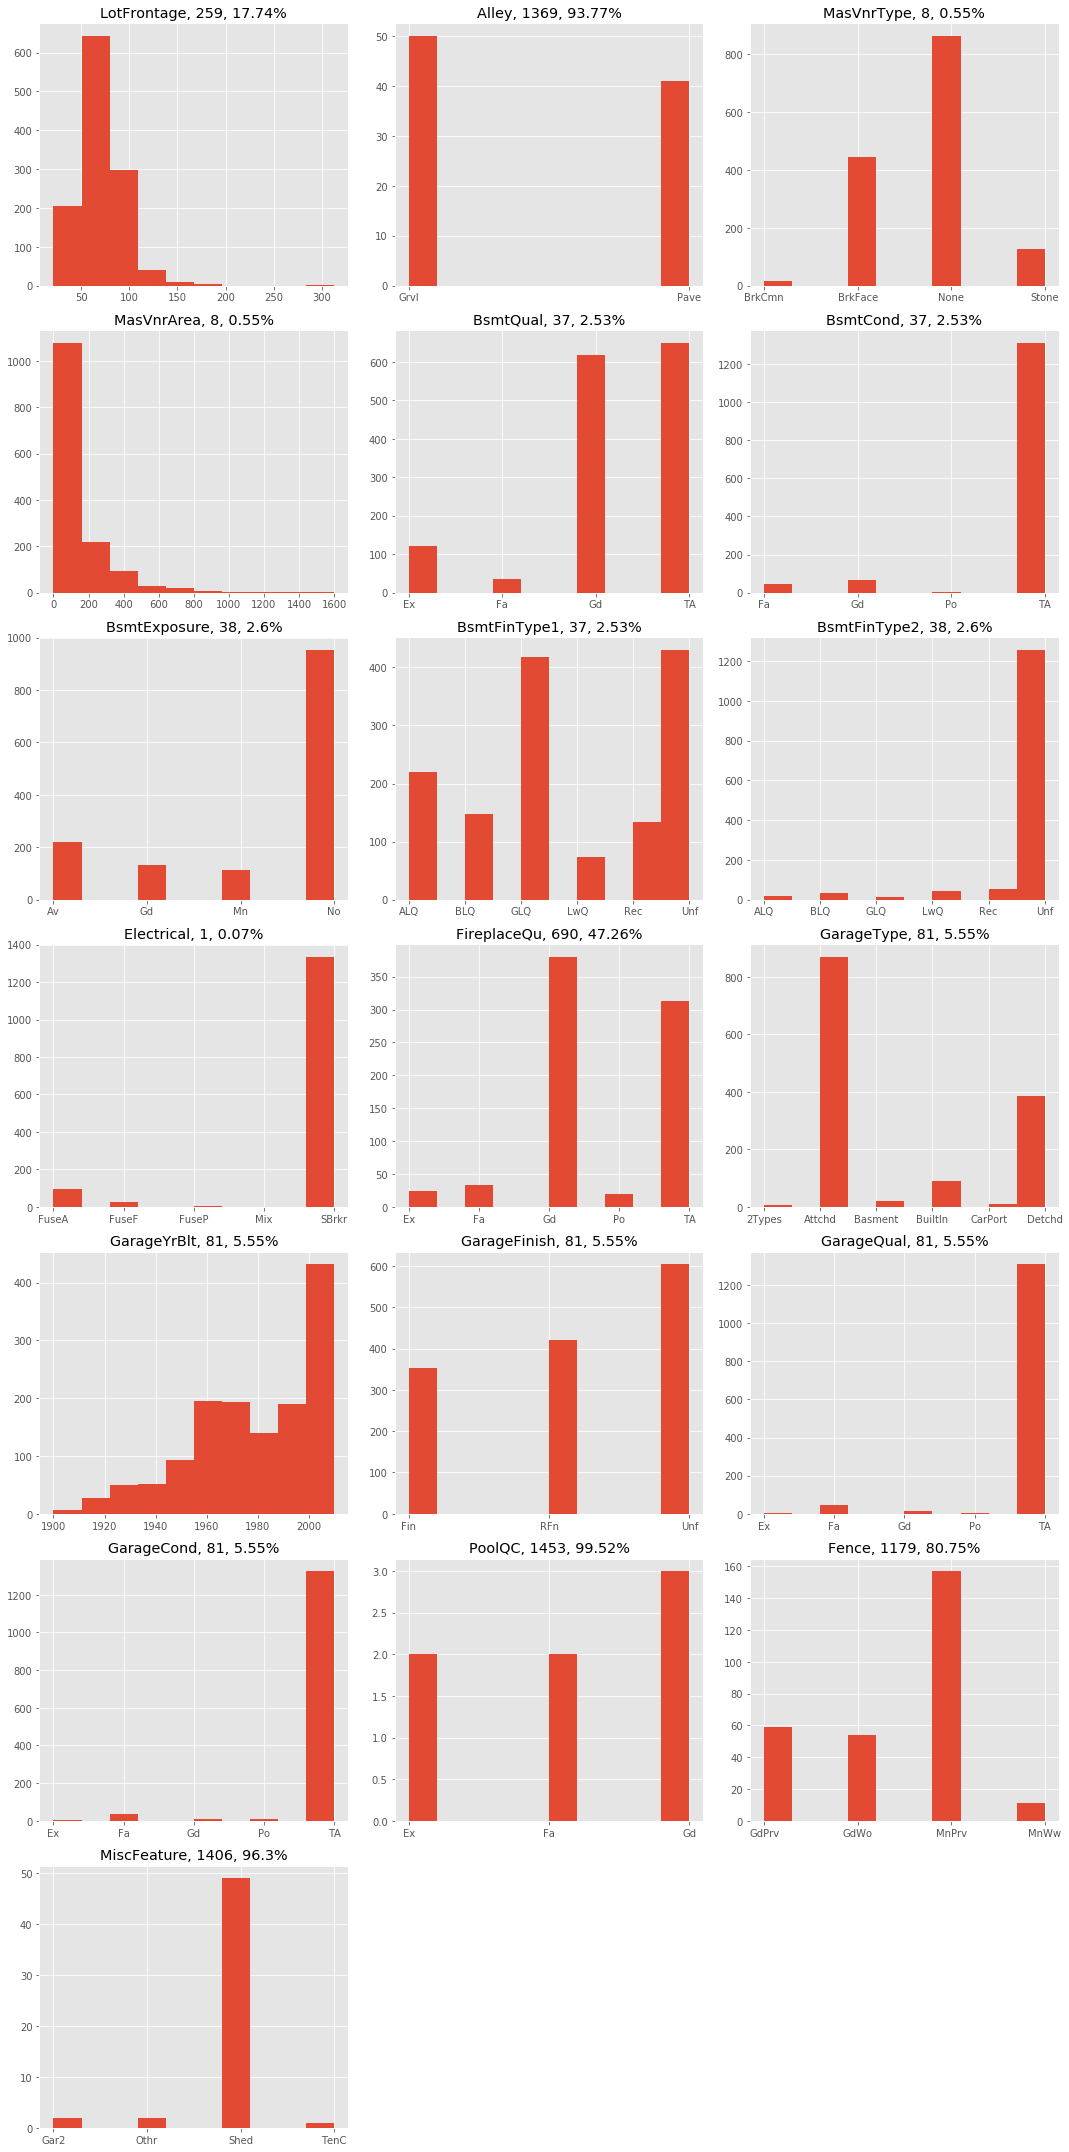

In [147]:


draw_histograms(df,df_null, cols_with_nulls,int(np.ceil(len(cols_with_nulls)/3)), 3)

We observe four types features with missing values:
- Features with data majorly missing and no observable distribution. We drop these columns.
- Features with visible distributions and significant data missing (aroung 40 or even 60 0r 70%). We generate random variates from these distributions and fill in the missing values. Another way to impute these values is by using the target as a predictor for these values and filling in these values.
- Features with very few values missing. These are imputed in two ways. First using the mode if the majority of the data is of one type. The second method is to use proportionate number of all values if the data is well distributed across between all possible values of that feature. 

### Drop columns

In [148]:
df=df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

In [149]:
numeric_cols = df._get_numeric_data().columns
print(numeric_cols)
cat_cols = np.array(set(df.columns)-set(numeric_cols))
# print(numeric_cols[0])
cat_cols=df.select_dtypes(['object']).columns
# cat_cols,type(cat_cols),cat_cols[0]
cat_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [272]:
print(len(cat_cols))
for c in cat_cols:
    print(df[c].value_counts(dropna=False))

17
RL         1145
RM          218
FV           62
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Lvl    1302
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
Inside     1045
Corner      262
CulDSac      93
FR2          47
FR3           4
Name: LotConfig, dtype: int64
NAmes      225
CollgCr    149
OldTown    113
Edwards    100
Somerst     83
Gilbert     78
NridgHt     76
Sawyer      74
NWAmes      73
SawyerW     58
BrkSide     58
Crawfor     50
Mitchel     49
NoRidge     41
IDOTRR      37
Timber      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
Norm      1251
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
other        7
Name: Condition1, dtype: int64
1Fam      1212
TwnhsE     113
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
Gable      1133
Hip         285
Fla

We drop 'Condition2','RoofMatl'.

In [151]:
df=df.drop(['Street','Utilities','Condition2','RoofMatl'],axis=1)

### Filling in columns with negligible number of missing values with 'Absent' because Nan here represents that these features are absent from the houses and are not real missing values.

In [152]:
cols_with_Na_as_none=['BsmtCond','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtExposure','FireplaceQu',
                      'GarageQual','GarageCond','GarageType','GarageFinish']

In [153]:
for c in cols_with_Na_as_none:
    df.ix[df[c].isnull(), c] = "Absent"
    print(c,df[c].isnull().sum(),df[c].unique())

BsmtCond 0 ['TA' 'Gd' 'Absent' 'Fa' 'Po']
BsmtFinType1 0 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Absent' 'LwQ']
BsmtFinType2 0 ['Unf' 'BLQ' 'Absent' 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtQual 0 ['Gd' 'TA' 'Ex' 'Absent' 'Fa']
BsmtExposure 0 ['No' 'Gd' 'Mn' 'Av' 'Absent']
FireplaceQu 0 ['Absent' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual 0 ['TA' 'Fa' 'Gd' 'Absent' 'Ex' 'Po']
GarageCond 0 ['TA' 'Fa' 'Absent' 'Gd' 'Po' 'Ex']
GarageType 0 ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'Absent' 'Basment' '2Types']
GarageFinish 0 ['RFn' 'Unf' 'Fin' 'Absent']


C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [154]:
for c in cols_with_Na_as_none:
#     df.ix[df[c].isnull(), c] = "Absent"
    print(c,df[c].isnull().sum(),df[c].unique())

BsmtCond 0 ['TA' 'Gd' 'Absent' 'Fa' 'Po']
BsmtFinType1 0 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Absent' 'LwQ']
BsmtFinType2 0 ['Unf' 'BLQ' 'Absent' 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtQual 0 ['Gd' 'TA' 'Ex' 'Absent' 'Fa']
BsmtExposure 0 ['No' 'Gd' 'Mn' 'Av' 'Absent']
FireplaceQu 0 ['Absent' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual 0 ['TA' 'Fa' 'Gd' 'Absent' 'Ex' 'Po']
GarageCond 0 ['TA' 'Fa' 'Absent' 'Gd' 'Po' 'Ex']
GarageType 0 ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'Absent' 'Basment' '2Types']
GarageFinish 0 ['RFn' 'Unf' 'Fin' 'Absent']


### Filling in columns with negligible number of missing values with the mode

In [155]:
cols_with_null_impute_mode=['MasVnrType','Electrical']
# df.fillna(df.mode()cols_with_null_impute_mode)
# df.fillna(df.mode()['B':'C'])
for c in cols_with_null_impute_mode:
    df.ix[df[c].isnull(), c] = df[c].mode().values
    
#check nans again
df_null,_=check_nan(df)
cols_with_nulls=df_null.index
len(cols_with_nulls),cols_with_nulls

             count   ratio(%)
LotFrontage    259  17.739726
MasVnrArea       8   0.547945
GarageYrBlt     81   5.547945


(3, Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'))

In [156]:
df.MasVnrType.value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

### Filling in missing values with random numbers imputed from distributions or using other formulae

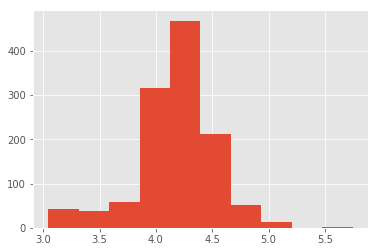

C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


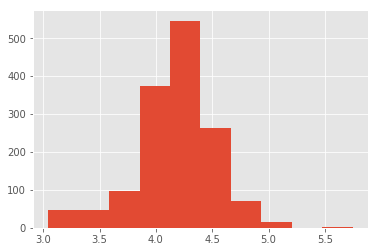

In [157]:
df['LotFrontage']=np.log(df['LotFrontage'])
df['LotFrontage'].hist()
plt.show()

#Impute and replace missing values
LotFrontage_mean = df['LotFrontage'].mean()
LotFrontage_std = df['LotFrontage'].std()
LotFrontage_null_count = df['LotFrontage'].isnull().sum()
    
imputed_fill_na = np.random.normal(loc=LotFrontage_mean, scale=LotFrontage_std, size=LotFrontage_null_count)
df['LotFrontage'][df['LotFrontage'].isnull()] = imputed_fill_na
del LotFrontage_mean,LotFrontage_std,LotFrontage_null_count
df['LotFrontage'].hist()
plt.show()

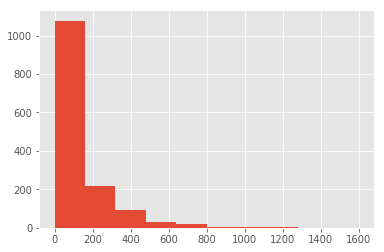

             count  ratio(%)
GarageYrBlt     81  5.547945


C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


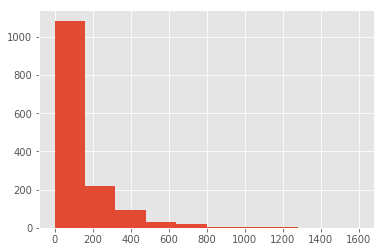

In [158]:
temp=df['MasVnrArea']
temp.mean()
temp.hist()
plt.show()
num_null = df['MasVnrArea'].isnull().sum()

imputed_fill_na = np.random.exponential(scale=(1/temp.mean()), size=num_null)
df['MasVnrArea'][df['MasVnrArea'].isnull()] = imputed_fill_na
df['MasVnrArea'].hist()
nan_data,_=check_nan(df)

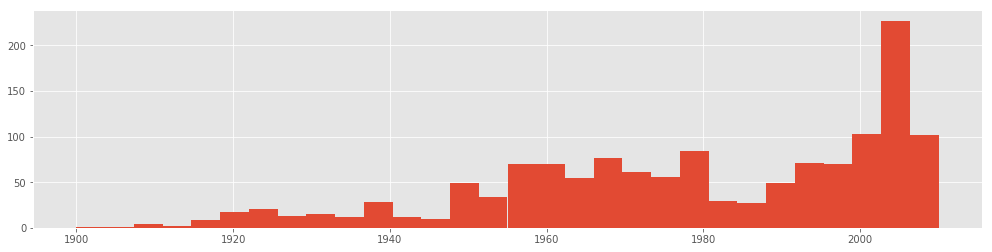

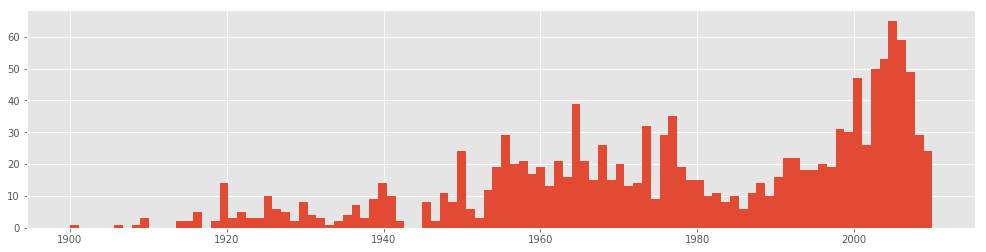

81 1978.5061638868744 98


In [198]:
fig=plt.figure(figsize=(17,4))
df['GarageYrBlt'].hist(bins=30)
plt.show()
fig=plt.figure(figsize=(17,4))
df['GarageYrBlt'].hist(bins=98)
plt.show()
# (df['GarageYrBlt']-df['GarageYrBlt'].mean()).hist() #just a linear transformaton so plot unchanged
# (1/df['GarageYrBlt']).hist() #stil; bi-modal
plt.show()
num_null = df['GarageYrBlt'].isnull().sum()
print(num_null,df['GarageYrBlt'].mean(),len(df['GarageYrBlt'].unique()))

Since this distribution is multi-modal with several nodes and does not follow a known continuous or discrete disrtibution, We simply add one value from each unique year because there are 98 unique possible year values and 81 missing values. If there were more missing values than unique values (say num_null = 2 x unique_vals), I would just sample each unique value twice, and so on! A more detailed way of replacing these missing values is also possible where the year is predicted using the sales price, etc.

In [199]:
imputed=-np.sort(-df['GarageYrBlt'].unique())[:num_null].astype(int)
print(len(imputed),num_null)
df['GarageYrBlt'][df['GarageYrBlt'].isnull()]=imputed
nan_data,_=check_nan(df)

81 81
Empty DataFrame
Columns: [count, ratio(%)]
Index: []


C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# IGNORE until next section on labeling data

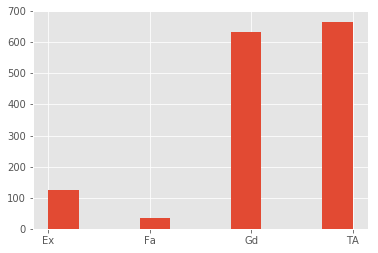

In [103]:
temp=df['BsmtQual']
temp.hist()
plt.show()
num_null = df['BsmtQual'].isnull().sum()

In [104]:
x=df.BsmtQual.value_counts()
print(x)
x.shape,sum(x),x[0]/sum(x),len(df.BsmtQual),x.index[0]

TA    666
Gd    634
Ex    124
Fa     36
Name: BsmtQual, dtype: int64


((4,), 1460, 0.45616438356164385, 1460, 'TA')

- log(p/(1-p)) = alpha + beta*SalesPrice
- if your salesprice 1e6, what's the probab caregory 1

In [105]:
def impute_discrete_dist_missing(df,df_cols):
    for c in df_cols:
        cat_cts=df[c].value_counts() #
        num_null = df[c].isnull().sum()
        num_not_null = sum(cat_cts)
        cats=cat_cts.index #unique category names
        imputed_vals=[]
        for i in range(len(cats)):
            if i<(len(cats)-1):
                imputed_vals=np.append(imputed_vals,np.repeat(cats[i],round((cat_cts[i]/num_not_null)*num_null,0)))
            else:
                imputed_vals=np.append(imputed_vals,np.repeat(cats[i],(num_null-len(imputed_vals))))
        df[c][df[c].isnull()] = imputed_vals
    return df

In [232]:
df=impute_discrete_dist_missing(df,np.array(nan_data.index))
_,_=check_nan(df)

Empty DataFrame
Columns: [count, ratio(%)]
Index: []


All missing values have been removed.

## Label Data

In [309]:
def plot_data_with_y(df, variables,numeric_cols,y, n_rows, n_cols):
    fig=plt.figure(figsize=(15,100))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        if var_name in numeric_cols:
            ax.scatter(df[var_name],y) 
            ax.set_xlabel(var_name)
            ax.set_ylabel('SalesPrice')
        else:
            sns.boxplot(df[var_name],y,ax=ax,color="red")
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

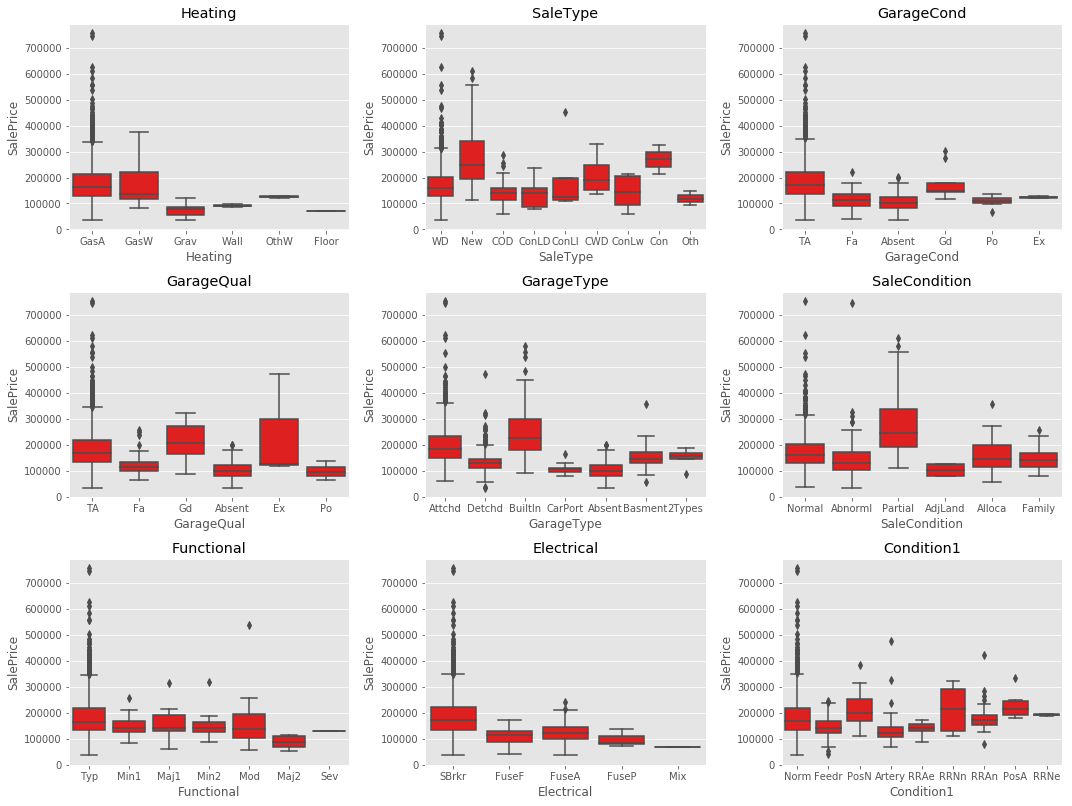

In [223]:
plot_data_with_y(df, make_others_col,[],y, 27, 3)

In [224]:
for c in make_others_col:
    print(df[c].value_counts())

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64
TA        1326
Absent      81
Fa          35
Gd           9
Po           7
Ex           2
Name: GarageCond, dtype: int64
TA        1311
Absent      81
Fa          48
Gd          14
Po           3
Ex           3
Name: GarageQual, dtype: int64
Attchd     870
Detchd     387
BuiltIn     88
Absent      81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
No

We only introduce "others" in the following features because visible difference are seen between their categories in the box plots:.

In [160]:
df['Heating'].replace(['Grav','Wall','OthW','Floor'],['other']*4,inplace=True)
df['Condition1'].replace(['RRNn','RRNe'],['other']*2,inplace=True)

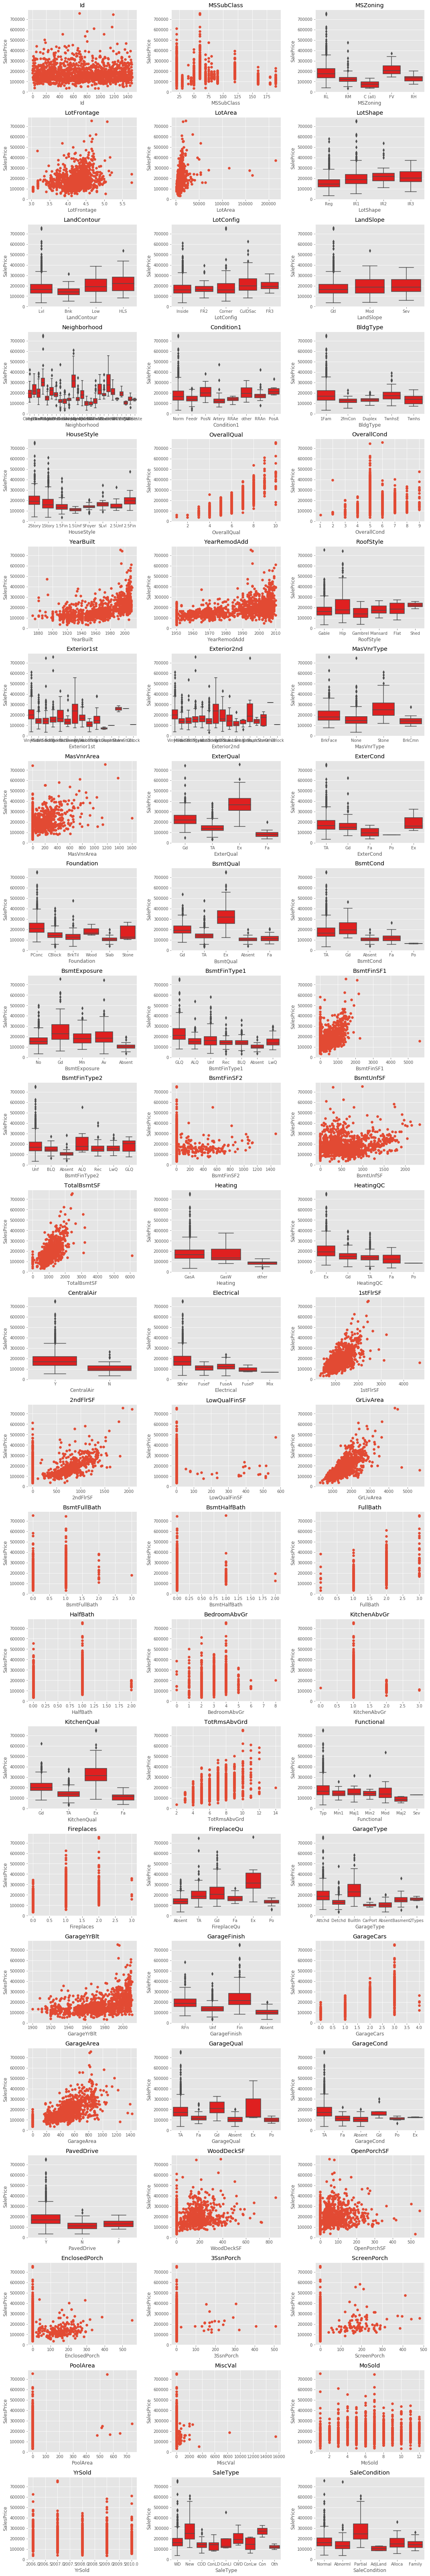

In [226]:
plot_data_with_y(df, df.columns,numeric_cols,y, 27, 3)

In [161]:
cat_cols=np.sort(df.select_dtypes(['object']).columns)
cat_cols

array(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'FireplaceQu', 'Foundation', 'Functional',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType',
       'Neighborhood', 'PavedDrive', 'RoofStyle', 'SaleCondition',
       'SaleType'], dtype=object)

In [162]:
label_cols=['LotShape','LandSlope','HouseStyle','ExterQual','ExterCond','BsmtCond','BsmtQual','BsmtExposure', 
            'BsmtFinType1','BsmtFinType2','HeatingQC','Functional','KitchenQual','FireplaceQu','GarageFinish',
           'GarageCond', 'GarageQual','PavedDrive']
dummy_encode_cols=np.array(set(cat_cols)-set(label_cols))
ord_n_num_cols=np.append(numeric_cols,label_cols)

In [163]:
for c in label_cols:
    print(c,df[c].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandSlope ['Gtl' 'Mod' 'Sev']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtCond ['TA' 'Gd' 'Absent' 'Fa' 'Po']
BsmtQual ['Gd' 'TA' 'Ex' 'Absent' 'Fa']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'Absent']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Absent' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'Absent' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu ['Absent' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'Absent']
GarageCond ['TA' 'Fa' 'Absent' 'Gd' 'Po' 'Ex']
GarageQual ['TA' 'Fa' 'Gd' 'Absent' 'Ex' 'Po']
PavedDrive ['Y' 'N' 'P']


In [164]:
df['LotShape'] = df['LotShape'].map({'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}).astype('int')
df['LandSlope'] = df['LandSlope'].map({'Gtl':0, 'Mod':1, 'Sev':2}).astype('int')
df['HouseStyle'] = df['HouseStyle'].map({'2Story':0, '1Story':1, '1.5Fin':2, '1.5Unf':3, 'SFoyer':4, 'SLvl':5,
                                       '2.5Unf':6, '2.5Fin':7}).astype('int')
df['ExterQual'] = df['ExterQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3}).astype('int')
df['ExterCond'] = df['ExterCond'].map({'TA':2, 'Gd':1, 'Fa':3, 'Po':4, 'Ex':0}).astype('int')
df['BsmtCond'] = df['BsmtCond'].map({'Gd':0, 'TA':1, 'Po':3, 'Fa':2,'Absent':4}).astype('int')
df['BsmtQual'] = df['BsmtQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3,'Absent':4}).astype('int')
df['BsmtExposure'] = df['BsmtExposure'].map({'No':3, 'Gd':0, 'Mn':2, 'Av':1,'Absent':4}).astype('int')
df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ':0, 'ALQ':1, 'Unf':5, 'Rec':3, 'BLQ':2, 'LwQ':4,
                                         'Absent':6}).astype('int')
df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ':0, 'ALQ':1, 'Unf':5, 'Rec':3, 'BLQ':2, 'LwQ':4,
                                         'Absent':6}).astype('int')
df['HeatingQC'] = df['HeatingQC'].map({'TA':2, 'Gd':1, 'Fa':3, 'Po':4, 'Ex':0}).astype('int')
df['Functional'] = df['Functional'].map({'Typ':0, 'Min1':1, 'Maj1':4, 'Min2':2, 'Mod':3, 'Maj2':5, 
                                         'Sev':5}).astype('int')
df['KitchenQual'] = df['KitchenQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3}).astype('int')
df['FireplaceQu'] = df['FireplaceQu'].map({'TA':2, 'Gd':1, 'Fa':3, 'Po':4, 'Ex':0,'Absent':5}).astype('int')
df['GarageFinish'] = df['GarageFinish'].map({'RFn':1, 'Unf':2, 'Fin':0, 'Absent':3}).astype('int')
df['GarageCond'] = df['GarageCond'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3,'Po':4,'Absent':5}).astype('int')
df['GarageQual'] = df['GarageQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3,'Po':4,'Absent':5}).astype('int')
df['PavedDrive'] = df['PavedDrive'].map({'Y':0, 'P':1, 'N':2}).astype('int')

In [165]:
for c in label_cols:
    print(c,df[c].unique())

LotShape [0 1 2 3]
LandSlope [0 1 2]
HouseStyle [0 1 2 3 4 5 6 7]
ExterQual [1 2 0 3]
ExterCond [2 1 3 4 0]
BsmtCond [1 0 4 2 3]
BsmtQual [1 2 0 4 3]
BsmtExposure [3 0 2 1 4]
BsmtFinType1 [0 1 5 3 2 6 4]
BsmtFinType2 [5 2 6 1 3 4 0]
HeatingQC [0 1 2 3 4]
Functional [0 1 4 2 3 5]
KitchenQual [1 2 0 3]
FireplaceQu [5 2 1 3 0 4]
GarageFinish [1 2 0 3]
GarageCond [2 3 5 1 4 0]
GarageQual [2 3 1 5 0 4]
PavedDrive [0 2 1]


In [181]:
df=df.drop('Id',axis=1)

In [182]:
df.to_pickle('df_imputedNAs_non_dummy.pickle')

## Find obvious correlations

In [245]:
correls=df[ord_n_num_cols].corr()
correls

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotShape,LandSlope,HouseStyle,ExterQual,ExterCond,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Functional,KitchenQual,FireplaceQu,GarageFinish,GarageCond,GarageQual,PavedDrive
Id,1.000000,0.011156,-0.027410,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051072,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,-0.053457,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.024071,0.005847,0.026166,-0.005039,-0.029860,-0.010085,0.032631,-0.017320,0.016882,0.030615,0.015001,0.002880,-0.014973,-0.001760,-0.013821,-0.008607,-0.013912,-0.005971
MSSubClass,0.011156,1.000000,-0.429466,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.075783,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.115361,-0.025672,0.080782,-0.016178,0.064686,0.015839,-0.060184,-0.051150,-0.027389,0.024330,0.019458,0.006695,0.012383,0.039201,0.033077,0.089846,0.072946,0.059925
LotFrontage,-0.027410,-0.429466,1.000000,0.241057,0.176827,-0.034609,0.063962,0.055263,0.124054,0.130385,0.032459,0.133547,0.281999,0.347217,0.043346,0.036144,0.294795,0.035150,0.007624,0.135774,0.013789,0.231013,0.013605,0.282325,0.183252,0.050320,0.241870,0.284593,0.073186,0.106351,0.001385,0.071361,0.054194,0.089930,-0.049071,0.033744,-0.000429,0.129644,0.074113,-0.006442,-0.124473,0.019149,-0.004395,-0.091956,-0.116893,-0.028511,-0.005104,-0.076104,-0.028501,-0.125990,-0.181380,-0.194268,-0.095958,-0.101715,-0.076375
LotArea,-0.033226,-0.139781,0.241057,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.017486,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.315484,0.436868,-0.008187,-0.055570,-0.014732,-0.031349,-0.076829,-0.228830,-0.058995,-0.086629,-0.003581,0.024514,-0.067864,-0.185332,-0.124756,-0.076097,-0.079313,-0.015134
OverallQual,-0.028365,0.032628,0.176827,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.517679,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.198994,-0.066450,-0.178803,-0.726278,-0.013953,-0.268759,-0.660767,-0.296517,-0.232503,0.044349,-0.457083,-0.146571,-0.673331,-0.490788,-0.556863,-0.286955,-0.292399,-0.229393
OverallCond,0.012609,-0.059316,-0.034609,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.302088,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.033747,0.010355,0.132787,0.138942,-0.389163,-0.132361,0.200969,0.056732,0.014479,-0.101674,0.014105,-0.119363,0.026707,0.056899,0.171245,-0.016706,-0.019060,0.062236
YearBuilt,-0.012713,0.027850,0.063962,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800

In [283]:
c1=[]
c2=[]
correl=[]
num_ord_cols=len(ord_n_num_cols)
for i in range(num_ord_cols-1):
    for j in np.arange((i+1),num_ord_cols):
        corr=correls.ix[i,j]
        if abs(corr)>0.6:
            c1=np.append(c1,ord_n_num_cols[i])
            c2=np.append(c2,ord_n_num_cols[j])
            correl=np.append(correl,corr)
df_correl=pd.DataFrame({'col1':c1,'col2':c2,'corr':correl,'abs_corr':abs(correl)})
df_correl.sort_values(by='abs_corr',ascending=False)

,abs_corr,col1,col2,corr
22,0.959172,GarageCond,GarageQual,0.959172
19,0.882475,GarageCars,GarageArea,0.882475
18,0.863241,Fireplaces,FireplaceQu,-0.863241
16,0.825489,GrLivArea,TotRmsAbvGrd,0.825489
11,0.819530,TotalBsmtSF,1stFlrSF,0.819530
10,0.788986,BsmtFinSF2,BsmtFinType2,-0.788986
4,0.774168,YearBuilt,GarageYrBlt,0.774168
1,0.726278,OverallQual,ExterQual,-0.726278
21,0.716122,ExterQual,KitchenQual,0.716122
9,0.695751,BsmtFinSF1,BsmtFinType1,-0.695751


In [315]:
df=df.drop(['GarageCond','GarageCars'],axis=1) #correlation close to 90%
df.shape

(1460, 70)

## get vif factor of above

# Dummy encode

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 70 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
LotShape         1460 non-null int32
LandContour      1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null int32
Neighborhood     1460 non-null object
Condition1       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null int32
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1460 non-null object
MasVnrArea       1460 non-null float64
ExterQual        1460 non-null int32
ExterCond        1460 non-nu

In [325]:
df2 = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],'C': [1, 2, 3]})
df2=pd.get_dummies(df2)
print(df2)
del df2

   C  A_a  A_b  B_a  B_b  B_c
0  1    1    0    0    1    0
1  2    0    1    1    0    0
2  3    1    0    0    0    1


In [323]:
cat_cols=df.select_dtypes(['object']).columns
len(cat_cols),cat_cols

(17,
 Index(['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
        'BldgType', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
        'SaleType', 'SaleCondition'],
       dtype='object'))

In [326]:
df.to_pickle('final_df.pickle')
print(df.shape)
y.to_pickle('final_y.pickle')
df=df.drop(['Id'],axis=1)
df=pd.get_dummies(df)#,drop_first=True) #,prefix=cat_cols #prefix parameter is not required because the column name becomes the default prefix
df.to_pickle('df_dummy.pickle')
df.shape

(1460, 70)


(1460, 184)

We are not dropping the first because it only adds 17 more columns. Also for Boosting trees etc, drop_first may not be needed as all categories of a feature are needed in these algos for modeling. For regression based algos, however, drop_first maybe needed.

# Modeling

## Data Prep

In [128]:
df=pd.read_pickle('df_dummy.pickle')
y=pd.read_pickle('final_y.pickle').values
print(y.shape, type(y), df.shape)
y=np.asarray(y)
x=np.asmatrix(df)
print(y.shape, x.shape)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_tr.shape, x_ts.shape, y_tr.shape, y_ts.shape)
ftrs=df.columns.values

(1460,) <class 'numpy.ndarray'> (1460, 183)
(1460,) (1460, 183)
(1168, 183) (292, 183) (1168,) (292,)


## XG Boost

In [56]:
import xgboost as xg

In [51]:
t=time()
xg1 = xg.XGBRegressor()
xg1.fit(x_tr, y_tr, verbose=False)
y_pred = xg1.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
# print('Classification Report:')
# print(classification_report(y_ts, y_pred, target_names=ftrs))
print('Time Take: ',round(time()-t,2),' secs')

Mean Absolute Error :  17396.05
R-squared:  84.43 %
Time Take:  0.89  secs


Obtaining a classification_report here does not male sense because we are prediciting the house price which is a continuous variable and not a categorical one with classes.

### XG Boost with parameter tuning

Setting number of trees with *n_estimators* and stopping with lesser number of trees using *early_stopping_rounds*

In [63]:
t=time()
xg2 = xg.XGBRegressor(n_estimators=1000)
xg2.fit(x_tr, y_tr, early_stopping_rounds=5, eval_set=[(x_ts, y_ts)], verbose=False)
y_pred = xg2.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),' secs')

Mean Absolute Error :  17704.17
R-squared:  83.65 %
Time Take:  0.75  secs


Reducing/adjusting the *learning_rate* to improve fit. Additional trees get lesser weight and this reduces the model's tendency to overfit.

In [67]:
t=time()
xg2 = xg.XGBRegressor(n_estimators=1000, learning_rate=0.05)
xg2.fit(x_tr, y_tr, early_stopping_rounds=5, eval_set=[(x_ts, y_ts)], verbose=False)
y_pred = xg2.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),' secs')

Mean Absolute Error :  17344.83
R-squared:  84.79 %
Time Take:  1.82  secs


In [10]:
t=time()
xg2 = xg.XGBRegressor(n_estimators=1000, learning_rate=0.01)
xg2.fit(x_tr, y_tr, early_stopping_rounds=5, eval_set=[(x_ts, y_ts)], verbose=False)
y_pred = xg2.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),' secs')

Mean Absolute Error :  18249.28
R-squared:  81.99 %
Time Take:  4.14  secs


### XG Boost with ADVANCED parameter tuning & sklearn Gridsearch

Setting number of trees with *n_estimators* and stopping with lesser number of trees using *early_stopping_rounds*

In [57]:
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

C:\Anaconda2\envs\cnn2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda2\envs\cnn2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [129]:
t=time()
param_grid = {
#               'nthread':[4], #when use hyperthread, xgboost may become slower
              'max_depth':[3,8],#[3,6,8,10],
              'min_child_weight':[10],#[8,10],
              'learning_rate':[0.1,0.01,0.001],#[0.1,0.05,0.01,0.005,0.001],
              'subsample':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'colsample_bytree':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'objective':['reg:linear'],
              'n_estimators':[1000],
              'silent': [0],#[1],#0 is the default and displays running messages. 0 recommended to understand model better
#               'missing':[-999],
              'seed': [1337]
             }
xg3 = XGBRegressor()
grid_search = GridSearchCV(xg3, param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

print ('Best parameters:', grid_search.best_params_)
print ('Best estimator:', grid_search.best_estimator_)
print ('Best score:', round(grid_search.best_score_*100,2))

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 1000, 'objective': 'reg:linear', 'seed': 1337, 'silent': 0, 'subsample': 0.6}
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.6)
Best score: 87.63


In [130]:
xg3 = XGBRegressor(**grid_search.best_params_)
xg3.fit(x_tr, y_tr, verbose=False)
y_pred = xg3.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),' secs')

Mean Absolute Error :  17507.56
R-squared:  86.55 %
Time Take:  212.34  secs


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001DD7F5F3CC0>>
Traceback (most recent call last):
  File "C:\Anaconda2\envs\cnn2\lib\site-packages\xgboost-0.7-py3.6.egg\xgboost\core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001DD7FEB5978>>
Traceback (most recent call last):
  File "C:\Anaconda2\envs\cnn2\lib\site-packages\xgboost-0.7-py3.6.egg\xgboost\core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


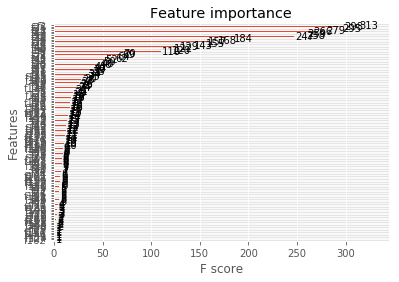

In [132]:
'''Plot the feature importance'''
from xgboost import plot_importance
plot_importance(xg3)
plt.show()

In [ ]:
params = {
'max_depth':3,
'min_child_weight':10,
'learning_rate':[0.1,0.05,0.01,0.005,0.001],
'subsample':0.5,
'colsample_bytree':0.6,
'obj':'reg:linear',
'n_estimators':1000,
'eta':0.01}

In [68]:
'''We won't be using this implementation but that in the next cell.'''
t=time()
dmatrix = xg.DMatrix(x_tr,y_tr,feature_names=ftrs)
clf = xg.train(params, dmatrix)
y_pred = clf.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),' secs')

AttributeError: 'matrix' object has no attribute 'feature_names'

In [82]:
def modelfit(alg, dtrain, predictors,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xg.DMatrix(dtrain[predictors].values, label=target)
        cvresult = xg.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
#                          , show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
#Choose all predictors except target & IDcols
predictors = ftrs#[x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, df, predictors,y_tr)

## Neural Net using Tensorflow

Parralelize for large data sets by setting *n_jobs = number of cores* on machines

In [52]:
import sys
print(sys.version)
sys.version_info

3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]


sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

Not worth it because such few data points.

# Drop Missing Data & Repeat XG Boost with

In [275]:
df=pd.read_pickle('train.pickle')
print(df.shape)
df_null,_=check_nan(df)
cols_with_nulls=df_null.index
len(cols_with_nulls),cols_with_nulls

(1460, 81)
              count   ratio(%)
LotFrontage     259  17.739726
Alley          1369  93.767123
MasVnrType        8   0.547945
MasVnrArea        8   0.547945
BsmtQual         37   2.534247
BsmtCond         37   2.534247
BsmtExposure     38   2.602740
BsmtFinType1     37   2.534247
BsmtFinType2     38   2.602740
Electrical        1   0.068493
FireplaceQu     690  47.260274
GarageType       81   5.547945
GarageYrBlt      81   5.547945
GarageFinish     81   5.547945
GarageQual       81   5.547945
GarageCond       81   5.547945
PoolQC         1453  99.520548
Fence          1179  80.753425
MiscFeature    1406  96.301370


(19, Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
        'MiscFeature'],
       dtype='object'))

In [276]:
drop_cols=df_null[df_null['ratio(%)']>40.00].index
drop_cols

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [277]:
df=df.drop(drop_cols,axis=1) 
df=df.drop(['Id'],axis=1)
df.shape

(1460, 75)

In [278]:
df=df.drop(['Street','Utilities','Condition2','RoofMatl'],axis=1)
df.shape, df.columns

((1460, 71),
 Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
        'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
        'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch'

In [279]:
cols_with_Na_as_none=['BsmtCond','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtExposure',
                      'GarageQual','GarageCond','GarageType','GarageFinish']
for c in cols_with_Na_as_none:
    df.ix[df[c].isnull(), c] = "Absent"
    print(c,df[c].isnull().sum(),df[c].unique())

BsmtCond 0 ['TA' 'Gd' 'Absent' 'Fa' 'Po']
BsmtFinType1 0 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Absent' 'LwQ']
BsmtFinType2 0 ['Unf' 'BLQ' 'Absent' 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtQual 0 ['Gd' 'TA' 'Ex' 'Absent' 'Fa']
BsmtExposure 0 ['No' 'Gd' 'Mn' 'Av' 'Absent']
GarageQual 0 ['TA' 'Fa' 'Gd' 'Absent' 'Ex' 'Po']
GarageCond 0 ['TA' 'Fa' 'Absent' 'Gd' 'Po' 'Ex']
GarageType 0 ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'Absent' 'Basment' '2Types']
GarageFinish 0 ['RFn' 'Unf' 'Fin' 'Absent']


C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [280]:
check_nan(df)

             count   ratio(%)
LotFrontage    259  17.739726
MasVnrType       8   0.547945
MasVnrArea       8   0.547945
Electrical       1   0.068493
GarageYrBlt     81   5.547945


(             count   ratio(%)
 LotFrontage    259  17.739726
 MasVnrType       8   0.547945
 MasVnrArea       8   0.547945
 Electrical       1   0.068493
 GarageYrBlt     81   5.547945,                count   ratio(%)
 MSSubClass         0   0.000000
 MSZoning           0   0.000000
 LotFrontage      259  17.739726
 LotArea            0   0.000000
 LotShape           0   0.000000
 LandContour        0   0.000000
 LotConfig          0   0.000000
 LandSlope          0   0.000000
 Neighborhood       0   0.000000
 Condition1         0   0.000000
 BldgType           0   0.000000
 HouseStyle         0   0.000000
 OverallQual        0   0.000000
 OverallCond        0   0.000000
 YearBuilt          0   0.000000
 YearRemodAdd       0   0.000000
 RoofStyle          0   0.000000
 Exterior1st        0   0.000000
 Exterior2nd        0   0.000000
 MasVnrType         8   0.547945
 MasVnrArea         8   0.547945
 ExterQual          0   0.000000
 ExterCond          0   0.000000
 Foundation         0 

In [281]:
df=df.drop(['LotFrontage','GarageYrBlt'],axis=1)
df.shape

(1460, 69)

In [282]:
df=df.dropna()
df.shape

(1451, 69)

In [283]:
y=df['SalePrice']
df=df.drop(['SalePrice'],axis=1)
df.shape

(1451, 68)

In [284]:
df['Heating'].replace(['Grav','Wall','OthW','Floor'],['other']*4,inplace=True)
df['Condition1'].replace(['RRNn','RRNe'],['other']*2,inplace=True)
df['LotShape'] = df['LotShape'].map({'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}).astype('int')
df['LandSlope'] = df['LandSlope'].map({'Gtl':0, 'Mod':1, 'Sev':2}).astype('int')
df['HouseStyle'] = df['HouseStyle'].map({'2Story':0, '1Story':1, '1.5Fin':2, '1.5Unf':3, 'SFoyer':4, 'SLvl':5,
                                       '2.5Unf':6, '2.5Fin':7}).astype('int')
df['ExterQual'] = df['ExterQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3}).astype('int')
df['ExterCond'] = df['ExterCond'].map({'TA':2, 'Gd':1, 'Fa':3, 'Po':4, 'Ex':0}).astype('int')
df['BsmtCond'] = df['BsmtCond'].map({'Gd':0, 'TA':1, 'Po':3, 'Fa':2,'Absent':4}).astype('int')
df['BsmtQual'] = df['BsmtQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3,'Absent':4}).astype('int')
df['BsmtExposure'] = df['BsmtExposure'].map({'No':3, 'Gd':0, 'Mn':2, 'Av':1,'Absent':4}).astype('int')
df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ':0, 'ALQ':1, 'Unf':5, 'Rec':3, 'BLQ':2, 'LwQ':4,
                                         'Absent':6}).astype('int')
df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ':0, 'ALQ':1, 'Unf':5, 'Rec':3, 'BLQ':2, 'LwQ':4,
                                         'Absent':6}).astype('int')
df['HeatingQC'] = df['HeatingQC'].map({'TA':2, 'Gd':1, 'Fa':3, 'Po':4, 'Ex':0}).astype('int')
df['Functional'] = df['Functional'].map({'Typ':0, 'Min1':1, 'Maj1':4, 'Min2':2, 'Mod':3, 'Maj2':5, 
                                         'Sev':5}).astype('int')
df['KitchenQual'] = df['KitchenQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3}).astype('int')
#column 'FireplaceQu' has been dropped # df['FireplaceQu'] = df['FireplaceQu'].map({'TA':2, 'Gd':1, 'Fa':3, 'Po':4, 'Ex':0,'Absent':5}).astype('int')
df['GarageFinish'] = df['GarageFinish'].map({'RFn':1, 'Unf':2, 'Fin':0, 'Absent':3}).astype('int')
df['GarageCond'] = df['GarageCond'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3,'Po':4,'Absent':5}).astype('int')
df['GarageQual'] = df['GarageQual'].map({'Gd':1, 'TA':2, 'Ex':0, 'Fa':3,'Po':4,'Absent':5}).astype('int')
df['PavedDrive'] = df['PavedDrive'].map({'Y':0, 'P':1, 'N':2}).astype('int')

In [254]:
_,df_correl=major_correls(df,0.6)
df_correl

C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,abs_corr,col1,col2,corr
19,0.959154,GarageQual,GarageCond,0.959154
18,0.882470,GarageCars,GarageArea,0.882470
16,0.825563,GrLivArea,TotRmsAbvGrd,0.825563
11,0.818107,TotalBsmtSF,1stFlrSF,0.818107
10,0.788881,BsmtFinType2,BsmtFinSF2,-0.788881
0,0.724739,OverallQual,ExterQual,-0.724739
7,0.715784,ExterQual,KitchenQual,0.715784
8,0.695117,BsmtFinType1,BsmtFinSF1,-0.695117
12,0.690403,2ndFlrSF,GrLivArea,0.690403
17,0.675590,BedroomAbvGr,TotRmsAbvGrd,0.675590


In [285]:
df=df.drop(['GarageQual','GarageCars'],axis=1)
df.shape

(1451, 66)

In [286]:
cat_cols=df.select_dtypes(['object']).columns
print(len(cat_cols),cat_cols)

17 Index(['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [287]:
df.to_pickle('df_nondummy_without_nans.pickle')
print(df.shape)
y.to_pickle('y_without_nans.pickle')
df=pd.get_dummies(df)#,drop_first=True) #,prefix=cat_cols #prefix parameter is not required because the column name becomes the default prefix
df.to_pickle('df_dummy_with_nans.pickle')
df.shape

(1451, 66)


(1451, 180)

In [288]:
x=np.asmatrix(df)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_tr.shape, x_ts.shape, y_tr.shape, y_ts.shape)
ftrs=df.columns.values

(1160, 180) (291, 180) (1160,) (291,)


In [289]:
t=time()
param_grid = {
#               'nthread':[4], #when use hyperthread, xgboost may become slower
              'max_depth':[3,8],#[3,6,8,10],
              'min_child_weight':[10],#[8,10],
              'learning_rate':[0.1,0.01,0.001],#[0.1,0.05,0.01,0.005,0.001],
              'subsample':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'colsample_bytree':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'objective':['reg:linear'],
              'n_estimators':[1000],
              'silent': [0],#[1],#0 is the default and displays running messages. 0 recommended to understand model better
#               'missing':[-999],
              'seed': [1337]
             }
xg5 = XGBRegressor()
grid_search = GridSearchCV(xg5, param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

print('Best parameters:', grid_search.best_params_)
print('Best estimator:', grid_search.best_estimator_)
print('Best score:', round(grid_search.best_score_*100,2),'%')
print('Time Take: ',round(time()-t,2),'s')

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 1000, 'objective': 'reg:linear', 'seed': 1337, 'silent': 0, 'subsample': 0.6}
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.6)
Best score: 83.93 %
Time Take:  225.19 s


In [127]:
t=time()
xg5 = XGBRegressor(**grid_search.best_params_)
xg5.fit(x_tr, y_tr, verbose=False)
y_pred = xg5.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),'s')

Mean Absolute Error :  13730.48
R-squared:  91.95 %
Time Take:  13.51 s


Note: Test set accuracy increase by ~4% by dropping missing data. Random replacement reduces model strenght.

### Fit on test data

In [291]:
df_ts=pd.read_csv('test.csv')

FileNotFoundError: File b'test.csv' does not exist

In [ ]:
df_ts.drop([''])

# Dropping based on VIF

## Data with Nans imputed randomly

### read data

In [201]:
df=pd.read_pickle('df_imputedNAs_non_dummy.pickle')
x=np.asmatrix(df)
y=pd.read_pickle('final_y.pickle').values
print(y.shape, type(y), x.shape)

(1460,) <class 'numpy.ndarray'> (1460, 71)


### vif 

In [219]:
all_vifs,main_vifs=major_vifs(df=df,thresh=10.0)

C:\Anaconda2\envs\cnn2\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Columns with high vif:
            cols           vif
17    BsmtFinSF1           inf
19    BsmtFinSF2           inf
26     GrLivArea           inf
25  LowQualFinSF           inf
24      2ndFlrSF           inf
23      1stFlrSF           inf
21   TotalBsmtSF           inf
20     BsmtUnfSF           inf
53        YrSold  3.942782e+04
8      YearBuilt  2.644217e+04
9   YearRemodAdd  2.628572e+04
38   GarageYrBlt  2.263070e+04
1    LotFrontage  2.230900e+02
43    GarageCond  1.393700e+02
42    GarageQual  1.359000e+02
18  BsmtFinType2  9.006000e+01
34  TotRmsAbvGrd  8.628000e+01
6    OverallQual  8.124000e+01
7    OverallCond  5.131000e+01
32  KitchenAbvGr  4.137000e+01
40    GarageCars  3.994000e+01
12     ExterCond  3.926000e+01
41    GarageArea  3.454000e+01
31  BedroomAbvGr  3.352000e+01
11     ExterQual  2.763000e+01
29      FullBath  2.726000e+01
37   FireplaceQu  2.007000e+01
13      BsmtQual  1.844000e+01
33   KitchenQual  1.643000e+01
14      BsmtCond  1.108000e+01
15  BsmtExposure

In [220]:
np.sort(all_vifs.vif.values)

array([1.050000e+00, 1.050000e+00, 1.120000e+00, 1.200000e+00,
       1.260000e+00, 1.270000e+00, 1.470000e+00, 1.500000e+00,
       1.610000e+00, 1.870000e+00, 1.880000e+00, 1.890000e+00,
       1.960000e+00, 2.610000e+00, 3.080000e+00, 3.400000e+00,
       3.580000e+00, 4.040000e+00, 5.560000e+00, 6.190000e+00,
       6.720000e+00, 7.160000e+00, 9.090000e+00, 1.012000e+01,
       1.108000e+01, 1.643000e+01, 1.844000e+01, 2.007000e+01,
       2.726000e+01, 2.763000e+01, 3.352000e+01, 3.454000e+01,
       3.926000e+01, 3.994000e+01, 4.137000e+01, 5.131000e+01,
       8.124000e+01, 8.628000e+01, 9.006000e+01, 1.359000e+02,
       1.393700e+02, 2.230900e+02, 2.263070e+04, 2.628572e+04,
       2.644217e+04, 3.942782e+04,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf,          inf])

In [222]:
df=df.drop(main_vifs.cols.values,axis=1)
df.shape

(1460, 40)

### xgboost on data without columns having high vifs and randomly imputed NAs

In [264]:
t=time()
param_grid = {
#               'nthread':[4], #when use hyperthread, xgboost may become slower
              'max_depth':[3,8],#[3,6,8,10],
              'min_child_weight':[10],#[8,10],
              'learning_rate':[0.1,0.01,0.001],#[0.1,0.05,0.01,0.005,0.001],
              'subsample':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'colsample_bytree':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'objective':['reg:linear'],
              'n_estimators':[1000],
              'silent': [0],#[1],#0 is the default and displays running messages. 0 recommended to understand model better
#               'missing':[-999],
              'seed': [1337]
             }
xg6 = XGBRegressor()
grid_search = GridSearchCV(xg6, param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

print('Best parameters:', grid_search.best_params_)
print('Best estimator:', grid_search.best_estimator_)
print('Best score:', round(grid_search.best_score_*100,2),'%')
print('Time Take: ',round(time()-t,2),'s')

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 1000, 'objective': 'reg:linear', 'seed': 1337, 'silent': 0, 'subsample': 0.6}
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.6)
Best score: 87.63 %
Time Take:  229.59 s


In [265]:
t=time()
xg6 = XGBRegressor(**grid_search.best_params_)
xg6.fit(x_tr, y_tr, verbose=False)
y_pred = xg6.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),'s')

Mean Absolute Error :  17507.56
R-squared:  86.55 %
Time Take:  5.42 s


Highest R-squafred so far of ~92%. Drop in R-squared suggests that power is lost. In fact a better R-squred is observed by blurring reality when we add randomly imputed data. Let's investigate adjusted R-squared and BIC statistic.

## Data without Nans randomly 

In [260]:
df=pd.read_pickle('df_nondummy_without_nans.pickle')
x=np.asmatrix(df)
y=np.array(pd.read_pickle('y_without_nans.pickle'))
print(y.shape, type(y), x.shape)

(1451,) <class 'numpy.ndarray'> (1451, 66)


### vif 

In [261]:
all_vifs,main_vifs=major_vifs(df=df,thresh=10.0)

C:\Anaconda2\envs\cnn2\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Columns with high vif:
            cols           vif
24  LowQualFinSF           inf
16    BsmtFinSF1           inf
25     GrLivArea           inf
23      2ndFlrSF           inf
22      1stFlrSF           inf
20   TotalBsmtSF           inf
19     BsmtUnfSF           inf
18    BsmtFinSF2           inf
48        YrSold  3.556236e+04
8   YearRemodAdd  2.510739e+04
7      YearBuilt  2.264780e+04
17  BsmtFinType2  8.915000e+01
33  TotRmsAbvGrd  8.509000e+01
5    OverallQual  8.034000e+01
6    OverallCond  5.051000e+01
31  KitchenAbvGr  4.043000e+01
11     ExterCond  3.871000e+01
30  BedroomAbvGr  3.278000e+01
10     ExterQual  2.765000e+01
28      FullBath  2.669000e+01
38    GarageCond  2.037000e+01
12      BsmtQual  1.805000e+01
32   KitchenQual  1.635000e+01
37    GarageArea  1.493000e+01
13      BsmtCond  1.109000e+01


In [262]:
np.sort(all_vifs.vif.values)

array([1.040000e+00, 1.040000e+00, 1.120000e+00, 1.200000e+00,
       1.260000e+00, 1.260000e+00, 1.460000e+00, 1.490000e+00,
       1.610000e+00, 1.840000e+00, 1.880000e+00, 1.910000e+00,
       1.930000e+00, 2.600000e+00, 3.040000e+00, 3.040000e+00,
       3.300000e+00, 3.540000e+00, 3.990000e+00, 4.600000e+00,
       6.160000e+00, 6.730000e+00, 6.980000e+00, 9.990000e+00,
       1.109000e+01, 1.493000e+01, 1.635000e+01, 1.805000e+01,
       2.037000e+01, 2.669000e+01, 2.765000e+01, 3.278000e+01,
       3.871000e+01, 4.043000e+01, 5.051000e+01, 8.034000e+01,
       8.509000e+01, 8.915000e+01, 2.264780e+04, 2.510739e+04,
       3.556236e+04,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                inf])

In [263]:
df=df.drop(main_vifs.cols.values,axis=1)
df.shape

(1451, 41)

### xgboost on data without columns having high vifs and randomly imputed NAs

In [266]:
t=time()
param_grid = {
#               'nthread':[4], #when use hyperthread, xgboost may become slower
              'max_depth':[3,8],#[3,6,8,10],
              'min_child_weight':[10],#[8,10],
              'learning_rate':[0.1,0.01,0.001],#[0.1,0.05,0.01,0.005,0.001],
              'subsample':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'colsample_bytree':[0.6],#[0.5,0.6,0.7,0.8,1.0],
              'objective':['reg:linear'],
              'n_estimators':[1000],
              'silent': [0],#[1],#0 is the default and displays running messages. 0 recommended to understand model better
#               'missing':[-999],
              'seed': [1337]
             }
xg7 = XGBRegressor()
grid_search = GridSearchCV(xg7, param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

print('Best parameters:', grid_search.best_params_)
print('Best estimator:', grid_search.best_estimator_)
print('Best score:', round(grid_search.best_score_*100,2),'%')
print('Time Take: ',round(time()-t,2),'s')

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 1000, 'objective': 'reg:linear', 'seed': 1337, 'silent': 0, 'subsample': 0.6}
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.6)
Best score: 87.63 %
Time Take:  226.53 s


In [267]:
t=time()
xg7 = XGBRegressor(**grid_search.best_params_)
xg7.fit(x_tr, y_tr, verbose=False)
y_pred = xg7.predict(x_ts)
print("Mean Absolute Error : ",round(mean_absolute_error(y_pred,y_ts),2))
print('R-squared: ',round(r2_score(y_pred,y_ts)*100,2),'%')
print('Time Take: ',round(time()-t,2),'s')

Mean Absolute Error :  17507.56
R-squared:  86.55 %
Time Take:  5.17 s


Highest R-squafred so far of ~92%. Drop in R-squared suggests that power is lost. In fact a better R-squred is observed by blurring reality when we add randomly imputed data. Let's investigate adjusted R-squared and BIC statistic.

# Predict Actual Test Data Using best method